In [1]:
# Install Modules

!pip install -U LibRecommender
!pip install libreco
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.8 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement libreco (from versions: none)
ERROR: No matching distribution found for libreco


In [2]:
# IMport Modules

import random
import warnings
import zipfile
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import tqdm

warnings.filterwarnings("ignore")

In [3]:
# Load Base folder

from google.colab import drive
drive.mount('/content/drive')

BASE_FOLDER = '/content/drive/MyDrive/research'

Mounted at /content/drive


In [4]:
## Bring in the Data

def load_ml_1m():
    # download and extract zip file
    tf.keras.utils.get_file(
        "ml-1m.zip",
        "http://files.grouplens.org/datasets/movielens/ml-1m.zip",
        cache_dir=".",
        cache_subdir=".",
        extract=True,
    )

    # read and merge data into same table
    cur_path = Path(".").absolute()

    #Ratings
    ratings = pd.read_csv(
        cur_path / "ml-1m" / "ratings.dat",
        sep="::",
        usecols=[0, 1, 2, 3],
        names=["user", "item", "rating", "time"],
    )

    #Users
    users = pd.read_csv(
        cur_path / "ml-1m" / "users.dat",
        sep="::",
        usecols=[0, 1, 2, 3],
        names=["user", "sex", "age", "occupation"],
    )

    # Movies
    items = pd.read_csv(
        cur_path / "ml-1m" / "movies.dat",
        sep="::",
        usecols=[0, 2],
        names=["item", "genre"],
        encoding="iso-8859-1",
    )

    items[["genre1", "genre2", "genre3"]] = (
        items["genre"].str.split(r"|", expand=True).fillna("missing").iloc[:, :3]
    )

    # Remove Duplicates
    items.drop("genre", axis=1, inplace=True)

    #Merged Data
    data = ratings.merge(users, on="user").merge(items, on="item")

    #Rename Rating Here as Label
    data.rename(columns={"rating": "label"}, inplace=True)

    #data = pd.merge(data, reviews, on='item')

    # random shuffle data
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)

    return data

data = load_ml_1m()

5917549/5917549 [==============================] - 1s 0us/step


In [5]:
data = load_ml_1m()
print("data shape:", data.shape)

data shape: (1000209, 10)


In [6]:
data.iloc[random.choices(range(len(data)), k=10)]  # randomly select 10 rows

,user,item,label,time,sex,age,occupation,genre1,genre2,genre3
509777,5387,1035,4,961192523,F,25,1,Musical,missing,missing
918986,636,3156,5,975753027,M,18,20,Comedy,Drama,Sci-Fi
32283,3760,1272,5,966097825,M,50,0,Drama,War,missing
922318,5890,720,3,957468420,M,35,20,Animation,missing,missing
771275,5260,3733,4,961201238,M,35,7,Drama,missing,missing
48264,3265,1591,3,968261112,M,25,15,Action,Adventure,Sci-Fi
338724,2178,16,3,974610533,M,45,14,Drama,Thriller,missing
849669,752,3785,3,991951512,F,25,3,Comedy,Horror,missing
562919,3454,1873,4,968195309,M,18,0,Drama,missing,missing
10233,3998,2287,5,965579696,M,45,0,Sci-Fi,Thriller,War


Load Dataset (with sentiment scores)

In [20]:
review_data = pd.read_csv('/content/drive/MyDrive/research/one_million_reviews.csv') # file with sentiment scores

In [21]:
# Check the shape
review_data.shape

(1000209, 8)

Merge the 2 dataset

In [22]:
# Merge the two DataFrames vertically (along the rows)
temp_data = pd.concat([review_data, data], axis=1)

Scores vs MovieID Distribution

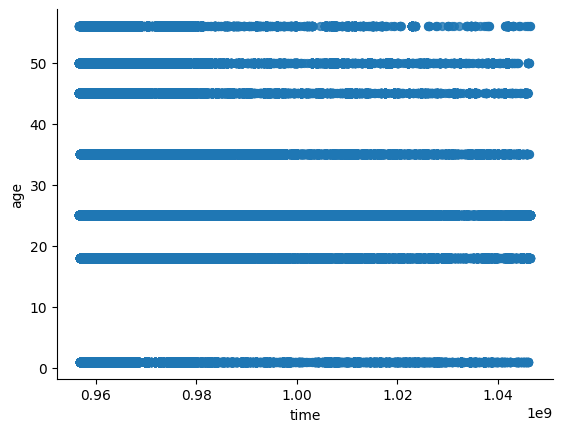

In [23]:
from matplotlib import pyplot as plt
temp_data.plot(kind='scatter', x='time', y='age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [24]:
temp_data.sample(3)

,movie,movieid,title,review,rating,movie_rating,sentiment,scores,user,item,label,time,sex,age,occupation,genre1,genre2,genre3
134017,Il Postino,14,Great foreign flick,easily within top ten foreign movies ranks das...,8/10,8,positive,4,5153,1476,3,961968364,M,25,7,Comedy,Drama,missing
222120,Toy Story,1,a wonderfully innovative movie; truly a delight,heartwarming story centers around group living...,7/10,7,slightly positive,3,2015,590,5,974757921,M,18,4,Adventure,Drama,Western
568701,Dances with Wolves,97,Dances with Sioux,really enjoyed movie majority time mainly foun...,4/10,4,slightly negative,1,2184,2976,4,974607466,M,18,4,Drama,Horror,missing


Specify The desired Order

In [25]:
# Specify the desired order of columns
temp_data = pd.DataFrame(temp_data)
desired_columns_order = ['user', 'item', *temp_data.columns.difference(['user', 'item'])]

# Reorder the columns in the DataFrame
final_data = temp_data[desired_columns_order]

In [26]:
final_data.sample(5)

,user,item,age,genre1,genre2,genre3,label,movie,movie_rating,movieid,occupation,rating,review,scores,sentiment,sex,time,title
483897,1015,2248,35,Comedy,Drama,Romance,5,Priest,1,57,3,1/10,priest one movies surrounded people ever remem...,0,negative,M,975016704,Excellent Film
165064,3457,3897,25,Comedy,Drama,missing,4,The Godfather,10,127,20,10/10,watching godfather requirement human godfather...,4,positive,M,977502489,Watching The Godfather is a requirement for Hu...
22897,4626,1480,25,Action,Drama,Thriller,2,The Godfather,9,127,14,9/10,nag dibendu nag born bought received dibendu n...,4,positive,M,964115401,Who is Prof.Dr.Dibendu Nag?
632588,6030,2012,25,Comedy,Sci-Fi,Western,3,Three Colors: Red,3,59,17,3/10,always heard movies polish director krzysztof ...,1,slightly negative,M,956718745,Pretentious time-waster
715762,3741,852,25,Comedy,Romance,missing,3,Jurassic Park,4,82,0,4/10,save charismatic presence sam neill samuel thi...,1,slightly negative,M,966160258,T- Rex & Laura's Legs


In [27]:
# Convert Scores from 0-4 to 1-5, same as the rating from 1 - 5
def scores_to_score(value):
    if value == 0:
      return 1
    elif value == 1:
      return 2
    elif value == 2:
      return 3
    elif value == 3:
      return 4
    else:
      return 5

In [28]:
final_data['score'] = final_data.scores.apply(scores_to_score)
final_data.sample(7)

,user,item,age,genre1,genre2,genre3,label,movie,movie_rating,movieid,occupation,rating,review,scores,sentiment,sex,time,title,score
397248,1936,589,35,Action,Sci-Fi,Thriller,3,Blade Runner,2,89,0,2/10,given ill generous go background whatever want...,0,negative,M,974703197,F**king waste of time,1
136440,3807,2263,35,Thriller,missing,missing,3,Jurassic Park,10,82,19,10/10,nothing gets better horror um ah um jeff suspe...,4,positive,F,970440118,My Favourite Movie Ever!,5
952416,4671,3639,25,Action,missing,missing,4,Pulp Fiction,7,56,12,7/10,personally thought film two thugs thug boss go...,3,slightly positive,M,963794283,What's the big deal about Tarantino movies!!!!...,4
110852,4207,3459,35,Drama,Horror,missing,3,The Shawshank Redemption,10,64,1,10/10,know people even bother making movies film wri...,4,positive,M,965323442,Greatest film written,5
229423,3332,2693,25,Documentary,missing,missing,5,The Godfather,7,127,7,7/10,yes great casting nice excellent however pace ...,3,slightly positive,M,967848682,"Good, not perfect",4
355409,1699,1267,25,Film-Noir,Thriller,missing,5,The Lion King,7,71,19,7/10,released christmas day imax large format lion ...,3,slightly positive,F,974709955,The Lion King: 9/10,4
461896,1592,2628,35,Action,Adventure,Fantasy,3,Reservoir Dogs,2,156,7,2/10,pulp fiction easy kill bill inglourious movie ...,0,negative,M,974735073,I generally like Tarantino.,1


In [29]:
# Drop columns: review, etc

processed_df = final_data.drop(columns=['movie','movie_rating','movieid','title','rating','review','scores','sentiment'])

In [30]:
# Check new Dataframe
processed_df.sample(3)

,user,item,age,genre1,genre2,genre3,label,occupation,sex,time,score
497099,5501,2879,25,Action,Adventure,Comedy,1,2,M,959798884,1
468290,442,1242,25,Action,Drama,War,5,1,M,978453358,1
60025,3491,168,25,Action,Adventure,Drama,3,16,M,967071634,5


In [31]:
# Check score type
processed_df['score'].dtype

dtype('int64')

In [32]:
processed_df['score'].isnull().sum()

0

In [33]:
print(processed_df['score'].unique())

[5 4 3 2 1]


In [34]:
processed_df

,user,item,age,genre1,genre2,genre3,label,occupation,sex,time,score
0,5755,184,35,Drama,missing,missing,3,2,F,958280246,5
1,4585,519,35,Sci-Fi,Thriller,missing,3,7,M,964321944,5
2,1503,3114,25,Animation,Children's,Comedy,4,12,M,974762175,5
3,2166,648,1,Action,Adventure,Mystery,4,10,M,974614593,5
4,3201,2178,45,Thriller,missing,missing,5,7,M,968626301,5
...,...,...,...,...,...,...,...,...,...,...,...
1000204,1509,2716,1,Comedy,Horror,missing,4,0,M,974747653,5
1000205,3756,1411,18,Drama,missing,missing,5,12,M,966096744,5
1000206,3609,1552,25,Action,Adventure,Thriller,3,17,F,966614629,4
1000207,4169,3639,50,Action,missing,missing,4,0,M,971579005,5


In [35]:
processed_df.sample(3)

,user,item,age,genre1,genre2,genre3,label,occupation,sex,time,score
995267,216,3258,45,Comedy,missing,missing,3,13,M,976864068,5
598178,2537,1955,35,Drama,missing,missing,3,11,M,974054281,2
17930,271,1262,18,Adventure,War,missing,5,4,M,976843772,5


In [ ]:
# processed_df['scores'] = processed_df['scores'].astype(int)

In [36]:
processed_df.to_csv('/content/drive/MyDrive/research/clean_data_1-5.csv',index=False)

# SPlit Data

In [37]:
clean_data = pd.read_csv('/content/drive/MyDrive/research/clean_data_1-5.csv') # file with everything needed for R System

In [38]:
clean_data

,user,item,age,genre1,genre2,genre3,label,occupation,sex,time,score
0,5755,184,35,Drama,missing,missing,3,2,F,958280246,5
1,4585,519,35,Sci-Fi,Thriller,missing,3,7,M,964321944,5
2,1503,3114,25,Animation,Children's,Comedy,4,12,M,974762175,5
3,2166,648,1,Action,Adventure,Mystery,4,10,M,974614593,5
4,3201,2178,45,Thriller,missing,missing,5,7,M,968626301,5
...,...,...,...,...,...,...,...,...,...,...,...
1000204,1509,2716,1,Comedy,Horror,missing,4,0,M,974747653,5
1000205,3756,1411,18,Drama,missing,missing,5,12,M,966096744,5
1000206,3609,1552,25,Action,Adventure,Thriller,3,17,F,966614629,4
1000207,4169,3639,50,Action,missing,missing,4,0,M,971579005,5


In [39]:
# SPlit Data

from libreco.data import random_split

# split data into three folds for training, evaluating and testing
first_half_data = clean_data[: (len(clean_data) // 2)] #I am using Full Data
train_data, eval_data, test_data = random_split(first_half_data, multi_ratios=[0.7, 0.15, 0.15], seed=42)

In [40]:
print("first half data shape:", first_half_data.shape)

first half data shape: (500104, 11)


In [41]:
from libreco.data import DatasetFeat

sparse_col = ["sex", "occupation", "genre1", "genre2", "genre3"]
# dense_col = ["age", "label"] # Without Sentiment Analysis
dense_col = ["age", "label", "score"] # With sentiment analysis Scores
# user_col = ["sex", "age", "label", "occupation"] # Without Sentiment analysis scores
user_col = ["sex", "age", "label", "score", "occupation"] # With Sentiment analysis scores
item_col = ["genre1", "genre2", "genre3"]

train_data, data_info = DatasetFeat.build_trainset(train_data, user_col, item_col, sparse_col, dense_col)
eval_data = DatasetFeat.build_evalset(eval_data)
test_data = DatasetFeat.build_testset(test_data)

In [42]:
print(type(train_data))

<class 'libreco.data.transformed.TransformedSet'>


In [43]:
print(data_info)

n_users: 6040, n_items: 3549, data density: 1.6331 %


In [44]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)


In [45]:
# Import DepFM and WideDeep
from libreco.algorithms import (
    DeepFM,
    WideDeep
    )

In [46]:
#Import DeepFM
# from libreco.algorithms import DeepFM

tf.compat.v1.reset_default_graph()

# n_epochs=4,
# dropout_rate=None,

deepfm = DeepFM(
    task="ranking",             # Use ranking task if appropriate
    data_info=data_info,        # Provide dataset information
    loss_type="cross_entropy",  # Use cross-entropy loss for classification tasks
    embed_size=16,              # Size of embedding vectors = 16 or 8
    n_epochs= 12,                # Increase the number of epochs for larger datasets - 5 or 12
    lr=0.001,                    # Adjust learning rate accordingly 1e-4 or 0.001 or 2e-5
    lr_decay=True,              # Enable learning rate decay for better convergence
    reg=None,                  # Apply regularization to prevent overfitting
    batch_size=1024,            # Adjust batch size based on available memory = 512 or 2048 or 1024
    num_neg=1,                  # Increase the number of negative samples for ranking tasks
    use_bn=True,                # Use batch normalization to stabilize training
    dropout_rate=None,           # Apply dropout regularization to prevent overfitting
    hidden_units=(256, 128, 64), # Increase the size of hidden layers for more capacity
    tf_sess_config=None,         # Use default TensorFlow session configuration
)

# Fit Model

deepfm.fit(
    train_data=train_data,
    neg_sampling=True,  # perform negative sampling on training and eval data
    verbose=2,
    shuffle=True,
    eval_data=eval_data,
    metrics=[
            "loss",
            "balanced_accuracy",
            "roc_auc",
            "pr_auc",
            "precision",
            "recall",
            "map",
            "ndcg",
        ],
)

Training start time: 2024-04-27 21:45:24
total params: 248,007 | embedding params: 164,908 | network params: 83,099
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 684/684 [00:22<00:00, 30.88it/s]


Epoch 1 elapsed: 22.155s
	 train_loss: 0.6266


eval_listwise: 100%|██████████| 2924/2924 [02:38<00:00, 18.51it/s]


	 eval log_loss: 0.5324
	 eval balanced_accuracy: 0.7350
	 eval roc_auc: 0.8081
	 eval pr_auc: 0.7797
	 eval precision@10: 0.0370
	 eval recall@10: 0.0395
	 eval map@10: 0.0997
	 eval ndcg@10: 0.1461
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 684/684 [00:18<00:00, 36.17it/s]


Epoch 2 elapsed: 18.916s
	 train_loss: 0.4618


eval_listwise: 100%|██████████| 2924/2924 [02:38<00:00, 18.43it/s]


	 eval log_loss: 0.5163
	 eval balanced_accuracy: 0.7518
	 eval roc_auc: 0.8295
	 eval pr_auc: 0.8024
	 eval precision@10: 0.0421
	 eval recall@10: 0.0485
	 eval map@10: 0.1095
	 eval ndcg@10: 0.1621
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 684/684 [00:20<00:00, 32.60it/s]


Epoch 3 elapsed: 20.993s
	 train_loss: 0.4377


eval_listwise: 100%|██████████| 2924/2924 [02:35<00:00, 18.78it/s]


	 eval log_loss: 0.5147
	 eval balanced_accuracy: 0.7558
	 eval roc_auc: 0.8335
	 eval pr_auc: 0.8071
	 eval precision@10: 0.0431
	 eval recall@10: 0.0496
	 eval map@10: 0.1104
	 eval ndcg@10: 0.1648
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 684/684 [00:19<00:00, 35.58it/s]


Epoch 4 elapsed: 19.241s
	 train_loss: 0.4225


eval_listwise: 100%|██████████| 2924/2924 [02:34<00:00, 18.95it/s]


	 eval log_loss: 0.5084
	 eval balanced_accuracy: 0.7596
	 eval roc_auc: 0.8393
	 eval pr_auc: 0.8127
	 eval precision@10: 0.0454
	 eval recall@10: 0.0522
	 eval map@10: 0.1155
	 eval ndcg@10: 0.1712
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 684/684 [00:20<00:00, 32.90it/s]


Epoch 5 elapsed: 20.796s
	 train_loss: 0.4097


eval_listwise: 100%|██████████| 2924/2924 [02:34<00:00, 18.87it/s]


	 eval log_loss: 0.5121
	 eval balanced_accuracy: 0.7636
	 eval roc_auc: 0.8407
	 eval pr_auc: 0.8152
	 eval precision@10: 0.0458
	 eval recall@10: 0.0542
	 eval map@10: 0.1200
	 eval ndcg@10: 0.1774
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 684/684 [00:19<00:00, 35.12it/s]


Epoch 6 elapsed: 19.484s
	 train_loss: 0.3993


eval_listwise: 100%|██████████| 2924/2924 [02:35<00:00, 18.81it/s]


	 eval log_loss: 0.5194
	 eval balanced_accuracy: 0.7613
	 eval roc_auc: 0.8397
	 eval pr_auc: 0.8132
	 eval precision@10: 0.0452
	 eval recall@10: 0.0540
	 eval map@10: 0.1149
	 eval ndcg@10: 0.1719
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 684/684 [00:18<00:00, 36.14it/s]


Epoch 7 elapsed: 18.931s
	 train_loss: 0.3906


eval_listwise: 100%|██████████| 2924/2924 [02:35<00:00, 18.75it/s]


	 eval log_loss: 0.5275
	 eval balanced_accuracy: 0.7645
	 eval roc_auc: 0.8429
	 eval pr_auc: 0.8183
	 eval precision@10: 0.0478
	 eval recall@10: 0.0559
	 eval map@10: 0.1193
	 eval ndcg@10: 0.1787
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 684/684 [00:18<00:00, 36.10it/s]


Epoch 8 elapsed: 18.958s
	 train_loss: 0.382


eval_listwise: 100%|██████████| 2924/2924 [02:35<00:00, 18.76it/s]


	 eval log_loss: 0.5328
	 eval balanced_accuracy: 0.7640
	 eval roc_auc: 0.8430
	 eval pr_auc: 0.8187
	 eval precision@10: 0.0470
	 eval recall@10: 0.0558
	 eval map@10: 0.1175
	 eval ndcg@10: 0.1768
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 684/684 [00:19<00:00, 35.01it/s]


Epoch 9 elapsed: 19.547s
	 train_loss: 0.375


eval_listwise: 100%|██████████| 2924/2924 [02:34<00:00, 18.98it/s]


	 eval log_loss: 0.5474
	 eval balanced_accuracy: 0.7659
	 eval roc_auc: 0.8462
	 eval pr_auc: 0.8216
	 eval precision@10: 0.0480
	 eval recall@10: 0.0562
	 eval map@10: 0.1223
	 eval ndcg@10: 0.1813
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 684/684 [00:20<00:00, 33.03it/s]


Epoch 10 elapsed: 20.719s
	 train_loss: 0.3687


eval_listwise: 100%|██████████| 2924/2924 [02:34<00:00, 18.87it/s]


	 eval log_loss: 0.5788
	 eval balanced_accuracy: 0.7612
	 eval roc_auc: 0.8422
	 eval pr_auc: 0.8183
	 eval precision@10: 0.0484
	 eval recall@10: 0.0573
	 eval map@10: 0.1251
	 eval ndcg@10: 0.1843
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 684/684 [00:19<00:00, 34.58it/s]


Epoch 11 elapsed: 19.786s
	 train_loss: 0.3632


eval_listwise: 100%|██████████| 2924/2924 [02:35<00:00, 18.76it/s]


	 eval log_loss: 0.5613
	 eval balanced_accuracy: 0.7660
	 eval roc_auc: 0.8441
	 eval pr_auc: 0.8199
	 eval precision@10: 0.0464
	 eval recall@10: 0.0544
	 eval map@10: 0.1164
	 eval ndcg@10: 0.1751
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 684/684 [00:18<00:00, 36.36it/s]


Epoch 12 elapsed: 18.824s
	 train_loss: 0.3573


eval_listwise: 100%|██████████| 2924/2924 [02:35<00:00, 18.76it/s]


	 eval log_loss: 0.6020
	 eval balanced_accuracy: 0.7617
	 eval roc_auc: 0.8442
	 eval pr_auc: 0.8200
	 eval precision@10: 0.0482
	 eval recall@10: 0.0556
	 eval map@10: 0.1208
	 eval ndcg@10: 0.1807


In [47]:
# Evaluate Test Data

from libreco.evaluation import evaluate

evaluate(
    model=deepfm,
    data=test_data,
    neg_sampling=True,  # No negative sampling on test data
    metrics=[
            "loss",
            "balanced_accuracy",
            "roc_auc",
            "pr_auc",
            "precision",
            "recall",
            "map",
            "ndcg",
        ],
)

eval_listwise: 100%|██████████| 2938/2938 [02:36<00:00, 18.73it/s]


{'loss': 0.6020177167550765,
 'balanced_accuracy': 0.7628265827342927,
 'roc_auc': 0.844104052413834,
 'pr_auc': 0.820587039214565,
 'precision': 0.04652825051055139,
 'recall': 0.056135677197922236,
 'map': 0.1190528878986511,
 'ndcg': 0.17736099654609894}

Plots

In [75]:
# predict preference of user 87711 to item 110
deepfm.predict(user=11, item=1262)

# Make Recommendation
# model.recommend_user(user=1, n_rec=3)

0.10018686

In [91]:
# Make recommendations based on User features
deepfm.recommend_user(user=110, n_rec=10, user_feats={"sex": "M", "age": 35})

{110: array([1645, 2389, 2713, 1717,  611, 2719,  196,  742, 1762, 1971])}

In [69]:
data_info.save("/content/drive/MyDrive/research/", model_name="deep_fm__enhanced_revised")
deepfm.save("/content/drive/MyDrive/research/", model_name="deep_fm_enhanced_revised")

WIDE DEEP

In [80]:
tf.compat.v1.reset_default_graph()

wd = WideDeep(
        "ranking",
        data_info,
        loss_type="cross_entropy",
        embed_size=16,
        n_epochs=5,
        lr={"wide": 0.01, "deep": 1e-4},
        lr_decay=False,
        reg=None,
        batch_size=2048,
        num_neg=1,
        use_bn=True,
        dropout_rate=None,
        hidden_units=(256, 128, 64),
        tf_sess_config=None,
)


wd.fit(
        train_data,
        neg_sampling=True,
        verbose=2,
        shuffle=True,
        eval_data=eval_data,
        metrics=[
            "loss",
            "balanced_accuracy",
            "roc_auc",
            "pr_auc",
            "precision",
            "recall",
            "map",
            "ndcg",
        ],
)

Training start time: 2024-04-27 23:00:28
total params: 247,990 | embedding params: 164,908 | network params: 83,082


train: 100%|██████████| 342/342 [00:22<00:00, 15.53it/s]


Epoch 1 elapsed: 22.022s
	 train_loss: 2.3543


eval_listwise: 100%|██████████| 2924/2924 [02:25<00:00, 20.08it/s]


	 eval log_loss: 0.6727
	 eval balanced_accuracy: 0.6330
	 eval roc_auc: 0.6924
	 eval pr_auc: 0.6939
	 eval precision@10: 0.0340
	 eval recall@10: 0.0357
	 eval map@10: 0.0906
	 eval ndcg@10: 0.1343


train: 100%|██████████| 342/342 [00:16<00:00, 20.51it/s]


Epoch 2 elapsed: 16.691s
	 train_loss: 0.7709


eval_listwise: 100%|██████████| 2924/2924 [02:20<00:00, 20.83it/s]


	 eval log_loss: 0.6318
	 eval balanced_accuracy: 0.6981
	 eval roc_auc: 0.7665
	 eval pr_auc: 0.7513
	 eval precision@10: 0.0427
	 eval recall@10: 0.0466
	 eval map@10: 0.1089
	 eval ndcg@10: 0.1626


train: 100%|██████████| 342/342 [00:16<00:00, 21.29it/s]


Epoch 3 elapsed: 16.080s
	 train_loss: 0.5658


eval_listwise: 100%|██████████| 2924/2924 [02:22<00:00, 20.54it/s]


	 eval log_loss: 0.5695
	 eval balanced_accuracy: 0.7174
	 eval roc_auc: 0.7864
	 eval pr_auc: 0.7588
	 eval precision@10: 0.0378
	 eval recall@10: 0.0417
	 eval map@10: 0.0980
	 eval ndcg@10: 0.1479


train: 100%|██████████| 342/342 [00:15<00:00, 21.48it/s]


Epoch 4 elapsed: 15.930s
	 train_loss: 0.5204


eval_listwise: 100%|██████████| 2924/2924 [02:22<00:00, 20.49it/s]


	 eval log_loss: 0.5511
	 eval balanced_accuracy: 0.7257
	 eval roc_auc: 0.7977
	 eval pr_auc: 0.7685
	 eval precision@10: 0.0366
	 eval recall@10: 0.0399
	 eval map@10: 0.0947
	 eval ndcg@10: 0.1428


train: 100%|██████████| 342/342 [00:15<00:00, 21.58it/s]


Epoch 5 elapsed: 15.855s
	 train_loss: 0.5056


eval_listwise: 100%|██████████| 2924/2924 [02:21<00:00, 20.63it/s]


	 eval log_loss: 0.5457
	 eval balanced_accuracy: 0.7271
	 eval roc_auc: 0.8002
	 eval pr_auc: 0.7706
	 eval precision@10: 0.0358
	 eval recall@10: 0.0400
	 eval map@10: 0.0942
	 eval ndcg@10: 0.1411


In [81]:
# Evaluate Test Data

from libreco.evaluation import evaluate

evaluate(
    model=wd,
    data=test_data,
    neg_sampling=True,  # No negative sampling on test data
    metrics=[
            "loss",
            "balanced_accuracy",
            "roc_auc",
            "pr_auc",
            "precision",
            "recall",
            "map",
            "ndcg",
        ],
)

eval_listwise: 100%|██████████| 2938/2938 [02:21<00:00, 20.75it/s]


{'loss': 0.5457618725575767,
 'balanced_accuracy': 0.7258505488056974,
 'roc_auc': 0.8000266884004101,
 'pr_auc': 0.7717817059892997,
 'precision': 0.03495575221238938,
 'recall': 0.038994248076771716,
 'map': 0.0900203644775407,
 'ndcg': 0.13536347669168963}

In [83]:
# predict preference of user 87711 to item 110
# wd.predict(user=87711, item=1690)

wd.predict(user=11, item=1262)

0.5408723

In [90]:
# Make Recommendation
# model.recommend_user(user=1, n_rec=3)


# Make recommendations based on User features
wd.recommend_user(user=110, n_rec=10, user_feats={"sex": "M", "age": 35})

{110: array([1197, 1527, 2455, 1580, 2664, 2407, 1215, 1374, 1544,  377])}

In [92]:
data_info.save("/content/drive/MyDrive/research/", model_name="wide_deep_enhanced_revised")
wd.save("/content/drive/MyDrive/research/", model_name="wide_deep_enhanced_revised")